<center><h1>Optimize delivery of packages using Drones</h1></center>
<br>
<left>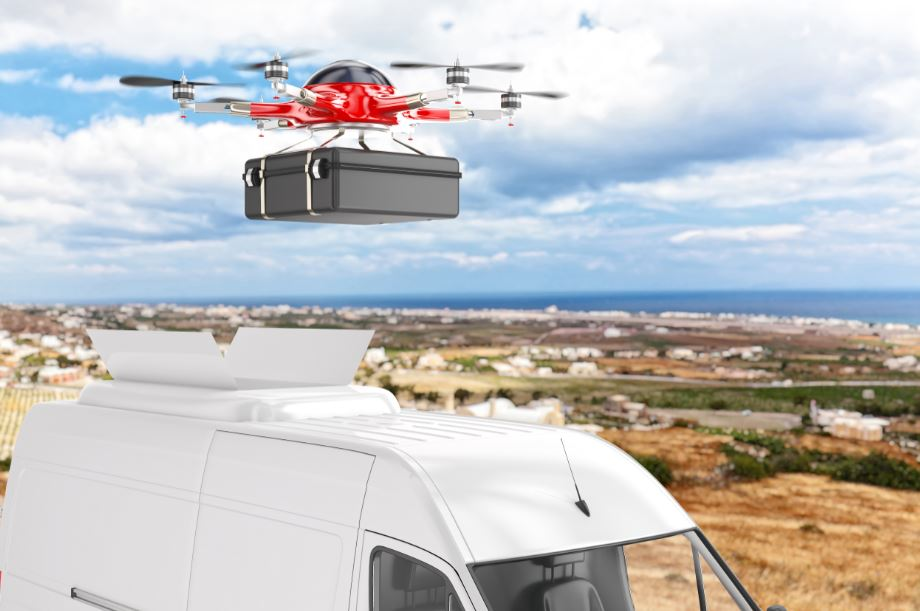</left>

Raster Analytics is seemlessly integrated with the Python API and ArcGIS Notebooks. It includes the ability to work with Raster Function Templates (RTFs) authored in ArcGIS Pro.

In [1]:
import arcgis
from arcgis.gis import GIS
gis = GIS("https://devsummitnotebooks.dev.geocloud.com/portal", "rjackson")

Enter password: ········


## Load Raster Function Templates

We'll take the function templates that have been authored in ArcGIS Pro, bring them into Python, and automate them for variables such as wind. ArcGIS Notebooks can be used as an IDE to script this workflow, and recompute the cost surfaces as conditions change. The resultant notebook can be downloaded as a Python script for batch processing, or executed on demand using the Cell > Run all menu.

<Item title:"rft_cost_surface" type:Raster function template owner:rjackson>
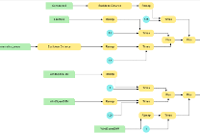

In [2]:
wind_cost_surface_rft = gis.content.search("title: rft_cost_surface", "Raster Function Template")[0] # RFT to Create Cost Surface Imagery Layer.
wind_cost_surface_rft

<Item title:"all_drones_path" type:Raster function template owner:portaladmin>
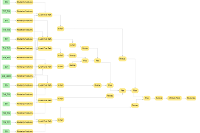

In [3]:
all_drone_paths_rft = gis.content.search("title: all_drones_path", "Raster Function Template")[0] # RFT to Find Optimum Flight Paths
all_drone_paths_rft

## Create Cost Surface 

The RFT class in the Python API can be used to work with Raster Function Templaces (RFTs) and visualize what they're doing. We don’t need to recreate the function chain in code, and can re-use the one created in ArcGIS Pro 

In [4]:
from arcgis.raster.functions import RFT        

wind_cost_surface = RFT(wind_cost_surface_rft)


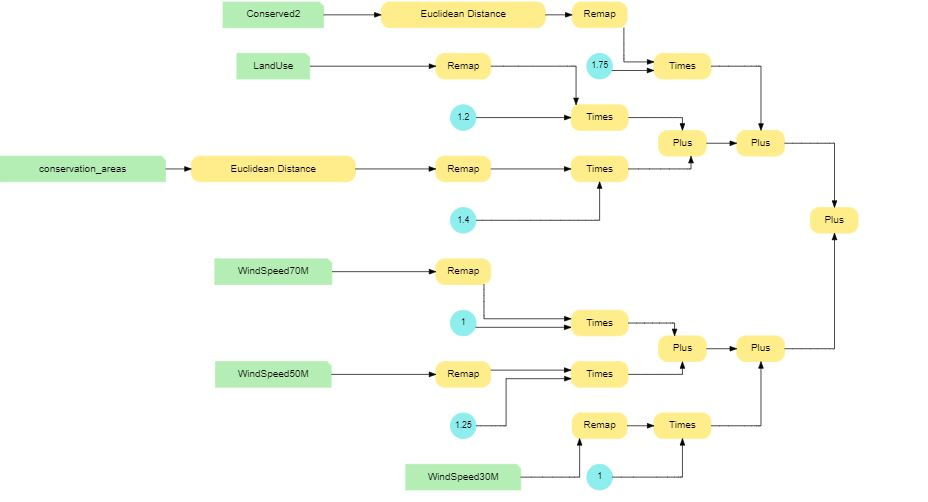

In [2]:
wind_cost_surface.draw_graph(graph_size='10, 6')

In [6]:
land_use        = gis.content.search("title: LandUse      AND owner:rjackson")[0].layers[0]
conserved_2     = gis.content.search("title: Conserved2   AND owner:rjackson")[0].layers[0]
conservation    = gis.content.search("title: Deer_Yards   AND owner:rjackson")[0].layers[0]
wind_speed_70m  = gis.content.search("title: WindSpeed70M AND owner:rjackson")[0].layers[0]
wind_speed_50m  = gis.content.search("title: WindSpeed50M AND owner:rjackson")[0].layers[0]
wind_speed_30m  = gis.content.search("title: WindSpeed30M AND owner:rjackson")[0].layers[0]

We can invoke the function chain by just calling it as a function and saving the results. This uses raster analytics to distribute the processing across a cluster of machines and persists the results as a new layer that can be visualized in the notebook.

Provide the values for the input parameters in the RFT object to create the Imagery Layer.

In [41]:
cost_surface = wind_cost_surface(Conserved2=conserved_2, LandUse=land_use,  conservation_areas=conservation, 
                                         WindSpeed70M=wind_speed_70m, 
                                         WindSpeed50M=wind_speed_50m, 
                                         WindSpeed30M=wind_speed_30m)

In [31]:
wind_cost_surface_item = cost_surface.save("cost_surface_layer") # uses raster analytics
wind_cost_surface_item

<Item title:"cost_surface_layer" type:Imagery Layer owner:rjackson>

In [23]:
wind_cost_surface_item = gis.content.search("title: cost_surface_layer")[0]

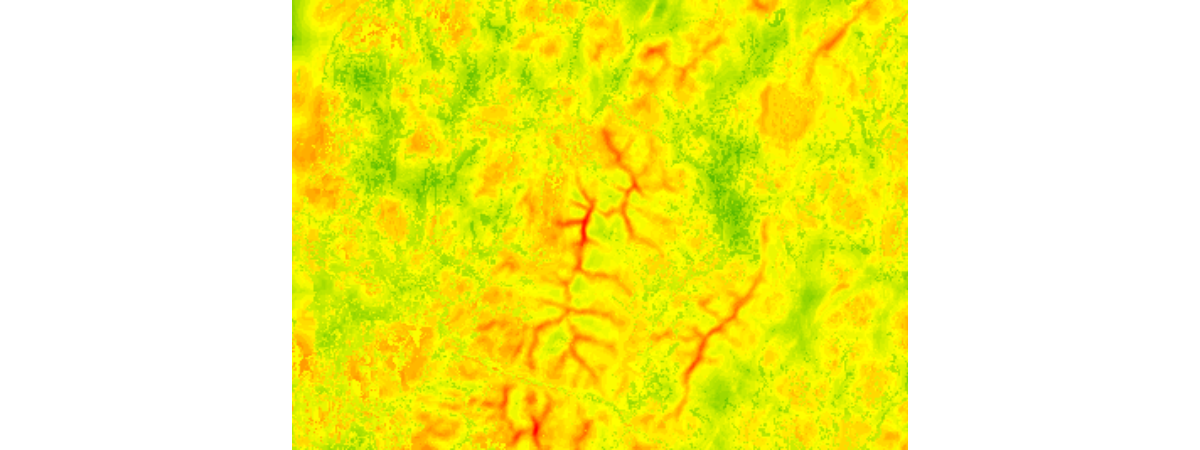

In [44]:
from arcgis.raster.functions import colormap, stretch # visualize cost surface

wind_cost_surface_layer = wind_cost_surface_item.layers[0]
stretch_op = stretch(wind_cost_surface_layer, stretch_type='MinMax', dra=True)
wind_cost_surface_layer_color_map = colormap(stretch_op, colorramp="Slope")
wind_cost_surface_layer_color_map

## Finding the Optimum Flight Corridors

Now that we have computed the cost surface, we can derive optimum flight paths. That uses a more sophisticated script that takes in as inputs, the different delivery stops, the cost surface generated above, and includes logic to derive the drone flight corridors. 

In [6]:
all_drone_paths_rft_object = RFT(all_drone_paths_rft)

We can visualize the function chain and the help document specific to this RFT in order to understand the input parameters and the functions involved.


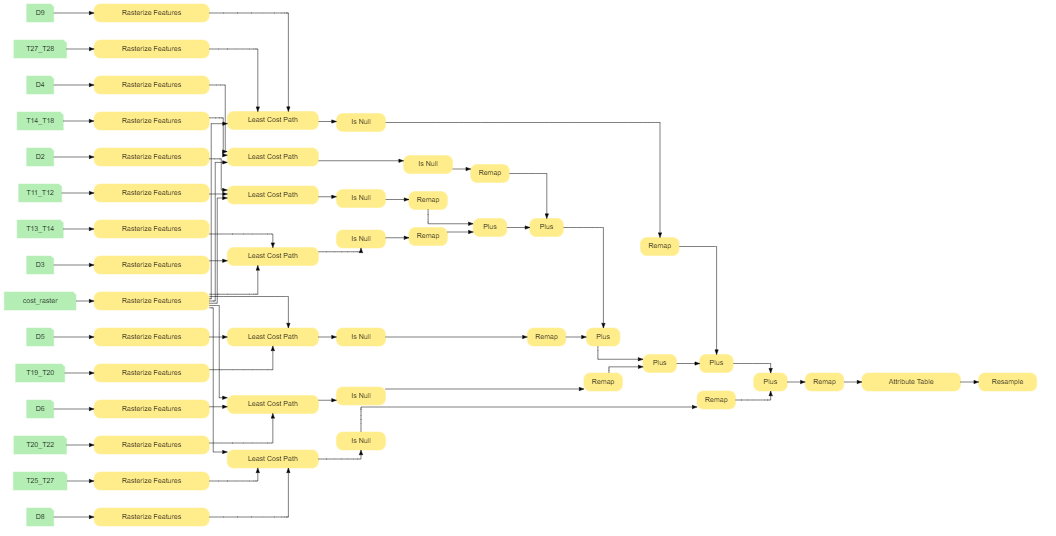

In [3]:
all_drone_paths_rft_object.draw_graph(graph_size='12, 9')

In [52]:
T14_T18 = gis.content.search("title: T14_T18 AND owner:rjackson")[0].layers[0]
T11_T12 = gis.content.search("title: T11_T12 AND owner:rjackson")[0].layers[0]
T13_T14 = gis.content.search("title: T13_T14 AND owner:rjackson")[0].layers[0]
T19_T20 = gis.content.search("title: T19_T20 AND owner:rjackson")[0].layers[0]
T27_T28 = gis.content.search("title: T27_T28 AND owner:rjackson")[0].layers[0]
T25_T27 = gis.content.search("title: T25_T27 AND owner:rjackson")[0].layers[0]
T20_T22 = gis.content.search("title: T20_T22 AND owner:rjackson")[0].layers[0]

d2 = gis.content.search("title: d2 AND owner:rjackson")[0].layers[0]
D3 = gis.content.search("title: D3 AND owner:rjackson")[0].layers[0]
D5 = gis.content.search("title: D5 AND owner:rjackson")[0].layers[0]
D9 = gis.content.search("title: D9 AND owner:rjackson")[0].layers[0]
D8 = gis.content.search("title: D8 AND owner:rjackson")[0].layers[0]
D4 = gis.content.search("title: D4 AND owner:rjackson")[0].layers[0]
D6 = gis.content.search("title: D6 AND owner:rjackson")[0].layers[0]

Provide the values for the input parameters in the RFT object to create the Imagery Layer. Finally, convert it to a feature layer of the flight corridors.

In [40]:
best_flight_path = all_drone_paths_rft_object(D4=D4, T14_T18=T14_T18, cost_raster=wind_cost_surface_layer, D2=d2, T11_T12=T11_T12, D3=D3, T13_T14=T13_T14, D5=D5, T19_T20=T19_T20, D6=D6, T20_T22=T20_T22, D9=D9, T27_T28=T27_T28, D8=D8, T25_T27=T25_T27)

In [62]:
optimum_flight_paths_item = best_flight_path.save("optimum_drone_paths")
optimum_flight_paths_layer = optimum_flight_paths_item.layers[0]

output_feature_layer = optimum_flight_paths_layer.to_features(output_type='Line', output_name='optimum_flight_paths_lines')
output_feature_layer

<Item title:"optimum_flight_paths_lines" type:Feature Layer Collection owner:rjackson>

## Visualize routes

We can take these routes and visualize them on a map. 


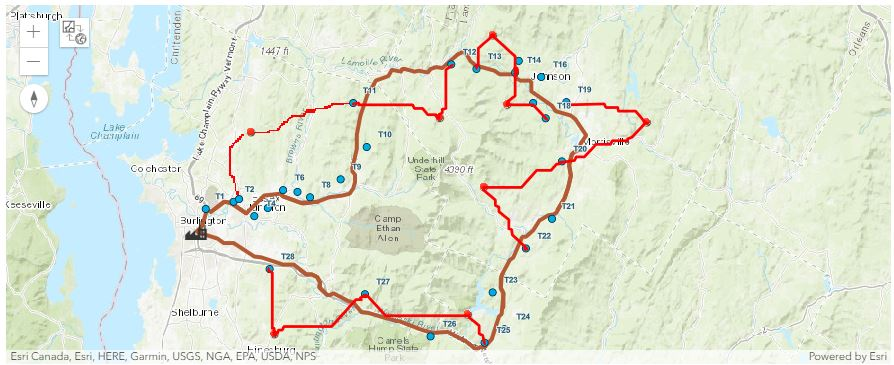

In [7]:
web_map = gis.content.get("77beab0294de4c03b92f0552bb77ba03")
map_widget = gis.map(web_map)
map_widget.zoom=10
map_widget

We can see the drone flight corridors mapped out, in Red, from the trucks where they are launched to each drone delivery point and back to the truck that has since moved to a different delivery location.

In [5]:
output_feature_layer = gis.content.search("title: optimum_flight_paths_lines", sort_field='', sort_order='')[0].layers[0]

In [6]:
map_widget.add_layer(output_feature_layer)

## For a fleet of drones

In [5]:
D2,D3,D5,D9,D8,D4,D6 = [],[],[],[],[],[],[]
optimum_flight_paths_item_list = []
optimum_flight_paths_feature_item_list = []
drone_names=['A','B','C','D']

In [18]:
for i in range(0, len(drone_names)):    
    D2.append(gis.content.search("title: "+drone_names[i]+"_D2 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    D3.append(gis.content.search("title: "+drone_names[i]+"_D3 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    D5.append(gis.content.search("title: "+drone_names[i]+"_D5 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    D9.append(gis.content.search("title: "+drone_names[i]+"_D9 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    D8.append(gis.content.search("title: "+drone_names[i]+"_D8 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    D4.append(gis.content.search("title: "+drone_names[i]+"_D4 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    D6.append(gis.content.search("title: "+drone_names[i]+"_D6 AND owner:admin", item_type='Imagery Layer', sort_field='', sort_order='')[0].layers[0])
    
    best_flight_path = all_drone_paths_rft_object(D4=D4[i], T14_T18=T14_T18, cost_raster=wind_cost_surface_layer, D2=D2[i], T11_T12=T11_T12, D3=D3[i], T13_T14=T13_T14, D5=D5[i], T19_T20=T19_T20, D6=D6[i], T20_T22=T20_T22, D9=D9[i], T27_T28=T27_T28, D8=D8[i], T25_T27=T25_T27)
    optimum_flight_paths_item_list.append(best_flight_path.save("optimum_drone_paths_"+drone_names[i]))
    optimum_flight_paths_feature_item_list.append(optimum_flight_paths_item_list[i].layers[0].to_features(output_type='Line', output_name='optimum_flight_paths_lines_drone_'+drone_names[i]))

### Results for a fleet of drones


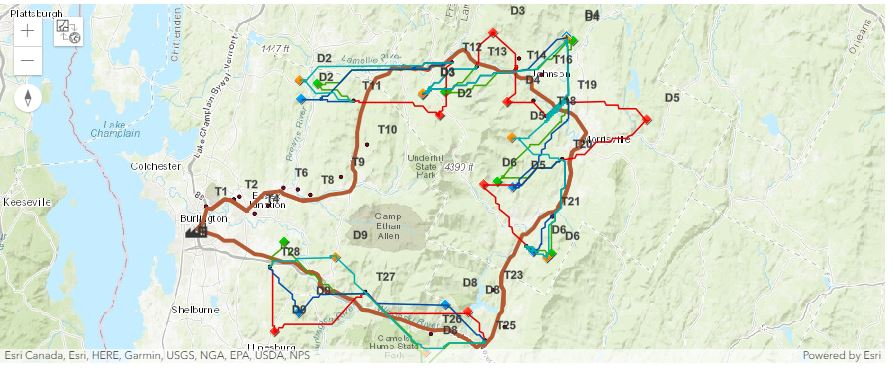

In [10]:
web_map = gis.content.get("96aac16ea87746fcae8f9b0070c9f375")
map_widget_fleet = gis.map(web_map)
map_widget_fleet.zoom=10
map_widget_fleet

In [9]:
drone_names=['A','B','C','D']
for i in range(0,len(drone_names)):
    map_widget_fleet.add_layer(gis.content.search("title: optimum_flight_paths_lines_drone_" + drone_names[i], sort_field='', sort_order='')[0].layers[0])
    